In [2]:
import os
import glob
import random
import numpy as np

In [3]:
ROOT = os.path.join(os.getcwd(),'img')
img_folders = {
    'clown':os.path.join(ROOT,'clown'),
    'shark':os.path.join(ROOT,'shark'),
    'reef':os.path.join(ROOT,'reef')
}

In [4]:
RESULT = {
    0:'Clown Fish',
    2:'Reef shark',
    1:'Other'
}
RESULT

{0: 'Clown Fish', 1: 'Other', 2: 'Reef shark'}

# All in one loading and preprocessing

In [5]:
import torch
from torchvision import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

In [6]:
def my_collate(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    target = torch.LongTensor(target)
    return [data, target]


train_transforms = transforms.Compose([transforms.Resize(size=128),
                                       transforms.CenterCrop(size=128),
                                       transforms.ToTensor(),
                                       ])

# change root to valid dir in your system, see ImageFolder documentation for more info
dataset = datasets.ImageFolder(root=ROOT,
                                    transform=train_transforms)

In [7]:
N = round(len(dataset)*0.7)
indices = list(range(len(dataset)))
train_ids = list(np.random.choice(indices,size=N,replace=False))
test_ids = list(set(indices) - set(train_ids))

In [8]:
from torch.utils.data.sampler import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_ids)
test_sampler = SubsetRandomSampler(test_ids)

In [9]:
trainset = DataLoader(dataset=dataset,
                      batch_size=8,
                      #shuffle=True,
                      sampler = train_sampler
                      #collate_fn=my_collate # use custom collate function here
                      )
testset = DataLoader(dataset=dataset,
                      batch_size=4,
                        #shuffle=True,
                      sampler = test_sampler
                      )

trainiter = iter(trainset)
imgs, labels = trainiter.next()

Reef shark


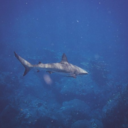

In [10]:
example = imgs[0]
print(RESULT[labels[0].item()])
transforms.ToPILImage()(example)

# Training part

# Define network

In [11]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [12]:
def abs_size(x):
    S = x.size()
    result = 1
    for s in S[1:]:
        result *= s
    return result

In [20]:
class FishNet(nn.Module):
    def __init__(self,number_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3)       # channels in, channels out, kernel size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 32, 3)      # 32 channels out
        self.apool = nn.AdaptiveAvgPool2d(8)
        self.fc1 = nn.Linear(8 * 8 * 32, 128)     # 8x8 square output, 16 layers
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, number_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.apool(x)
        x = x.view(-1, abs_size(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


mynet = FishNet(3)
mynet

FishNet(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1))
  (apool): AdaptiveAvgPool2d(output_size=8)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=3, bias=True)
)

## Optimizer

In [21]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mynet.parameters(), lr=0.01, momentum=0.8)

In [22]:
def adjust_learning_rate(optimizer, decay_factor=0.1):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= decay_factor
        
    return optimizer

In [23]:
def is_stagnant(L,n=10,eps=1e-2):
    M1 = np.mean(L[-2*n:-n])
    M2 = np.mean(L[-n:])
    D = (M1-M2)/(M1+M2)
    return abs(D)<eps

In [24]:
# TO DO
#optim.lr_scheduler.

## Train step

In [25]:
LOSSES = []
EPOCH_ELAPSED = 0

In [26]:
print_batch = 6
N_epoch = 200
epochs_since_last_decay = 0
decay = 4

for epoch in range(1,N_epoch+1):  # loop over the dataset multiple times
    
    print('\n','---------- Epoch {:03d} ----------'.format(EPOCH_ELAPSED))
    running_loss = 0.0
    
    for i, data in enumerate(trainset, 1):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = mynet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() #loss.data[0] deprecated in newer versions of PyTorch
        if i % print_batch == 0:    # print every few mini-batches
            LOSSES.append(running_loss)
            print('     Batch {:02d} | Loss: {:.4f}'.format(i ,running_loss / print_batch))
            running_loss = 0.0
            
    # Decay LR when learning is stalling, for better convergence
    if epochs_since_last_decay>5 and is_stagnant(LOSSES,3):
        optimizer = adjust_learning_rate(optimizer,decay_factor=1.0/decay)
        epochs_since_last_decay = 0
        print('\n','='*10,'LR decayed by',decay,'='*10,'\n')
    
    # Some updating
    epochs_since_last_decay += 1
    EPOCH_ELAPSED += 1
            
print('Finished Training')


 ---------- Epoch 000 ----------
     Batch 06 | Loss: 1.1161
     Batch 12 | Loss: 1.0944
     Batch 18 | Loss: 1.0593
     Batch 24 | Loss: 1.0585
     Batch 30 | Loss: 1.0624
     Batch 36 | Loss: 1.0303
     Batch 42 | Loss: 1.0661

 ---------- Epoch 001 ----------
     Batch 06 | Loss: 1.0301
     Batch 12 | Loss: 1.0500
     Batch 18 | Loss: 1.0112
     Batch 24 | Loss: 0.9932
     Batch 30 | Loss: 1.0386
     Batch 36 | Loss: 0.9699
     Batch 42 | Loss: 0.9194

 ---------- Epoch 002 ----------
     Batch 06 | Loss: 0.9158
     Batch 12 | Loss: 1.0070
     Batch 18 | Loss: 0.9540
     Batch 24 | Loss: 0.8982
     Batch 30 | Loss: 0.7616
     Batch 36 | Loss: 0.8453
     Batch 42 | Loss: 0.7607

 ---------- Epoch 003 ----------
     Batch 06 | Loss: 0.6959
     Batch 12 | Loss: 0.6070
     Batch 18 | Loss: 0.5956
     Batch 24 | Loss: 0.7574
     Batch 30 | Loss: 0.7846
     Batch 36 | Loss: 0.7689
     Batch 42 | Loss: 0.5390

 ---------- Epoch 004 ----------
     Batch 06 | Lo

     Batch 24 | Loss: 0.1825
     Batch 30 | Loss: 0.2655
     Batch 36 | Loss: 0.2603
     Batch 42 | Loss: 0.1611

 ---------- Epoch 035 ----------
     Batch 06 | Loss: 0.2306
     Batch 12 | Loss: 0.1601
     Batch 18 | Loss: 0.1893
     Batch 24 | Loss: 0.3158
     Batch 30 | Loss: 0.2067
     Batch 36 | Loss: 0.2044
     Batch 42 | Loss: 0.1910

 ---------- Epoch 036 ----------
     Batch 06 | Loss: 0.2274
     Batch 12 | Loss: 0.1540
     Batch 18 | Loss: 0.2149
     Batch 24 | Loss: 0.2777
     Batch 30 | Loss: 0.1864
     Batch 36 | Loss: 0.1461
     Batch 42 | Loss: 0.1878

 ---------- Epoch 037 ----------
     Batch 06 | Loss: 0.2379
     Batch 12 | Loss: 0.2116
     Batch 18 | Loss: 0.2238
     Batch 24 | Loss: 0.1467
     Batch 30 | Loss: 0.1054
     Batch 36 | Loss: 0.1938
     Batch 42 | Loss: 0.1798

 ---------- Epoch 038 ----------
     Batch 06 | Loss: 0.1819
     Batch 12 | Loss: 0.2928
     Batch 18 | Loss: 0.1757
     Batch 24 | Loss: 0.1362
     Batch 30 | Loss: 0

     Batch 06 | Loss: 0.1664
     Batch 12 | Loss: 0.0285
     Batch 18 | Loss: 0.1035
     Batch 24 | Loss: 0.0716
     Batch 30 | Loss: 0.0556
     Batch 36 | Loss: 0.0731
     Batch 42 | Loss: 0.0571

 ---------- Epoch 070 ----------
     Batch 06 | Loss: 0.0594
     Batch 12 | Loss: 0.0393
     Batch 18 | Loss: 0.0424
     Batch 24 | Loss: 0.0514
     Batch 30 | Loss: 0.1426
     Batch 36 | Loss: 0.1085
     Batch 42 | Loss: 0.1022

 ---------- Epoch 071 ----------
     Batch 06 | Loss: 0.1424
     Batch 12 | Loss: 0.0636
     Batch 18 | Loss: 0.0946
     Batch 24 | Loss: 0.0632
     Batch 30 | Loss: 0.0363
     Batch 36 | Loss: 0.0936
     Batch 42 | Loss: 0.0517

 ---------- Epoch 072 ----------
     Batch 06 | Loss: 0.1552
     Batch 12 | Loss: 0.0381
     Batch 18 | Loss: 0.0657
     Batch 24 | Loss: 0.0938
     Batch 30 | Loss: 0.0462
     Batch 36 | Loss: 0.0888
     Batch 42 | Loss: 0.0610

 ---------- Epoch 073 ----------
     Batch 06 | Loss: 0.1202
     Batch 12 | Loss: 0

     Batch 36 | Loss: 0.0421
     Batch 42 | Loss: 0.1044

 ---------- Epoch 104 ----------
     Batch 06 | Loss: 0.0349
     Batch 12 | Loss: 0.0464
     Batch 18 | Loss: 0.0321
     Batch 24 | Loss: 0.1024
     Batch 30 | Loss: 0.1444
     Batch 36 | Loss: 0.0407
     Batch 42 | Loss: 0.0848

 ---------- Epoch 105 ----------
     Batch 06 | Loss: 0.1266
     Batch 12 | Loss: 0.0956
     Batch 18 | Loss: 0.0372
     Batch 24 | Loss: 0.0421
     Batch 30 | Loss: 0.0440
     Batch 36 | Loss: 0.0502
     Batch 42 | Loss: 0.0859

 ---------- Epoch 106 ----------
     Batch 06 | Loss: 0.1382
     Batch 12 | Loss: 0.0708
     Batch 18 | Loss: 0.0745
     Batch 24 | Loss: 0.0234
     Batch 30 | Loss: 0.0468
     Batch 36 | Loss: 0.0765
     Batch 42 | Loss: 0.0521

 ---------- Epoch 107 ----------
     Batch 06 | Loss: 0.0872
     Batch 12 | Loss: 0.0820
     Batch 18 | Loss: 0.0413
     Batch 24 | Loss: 0.0446
     Batch 30 | Loss: 0.0427
     Batch 36 | Loss: 0.1055
     Batch 42 | Loss: 0

     Batch 18 | Loss: 0.0853
     Batch 24 | Loss: 0.0587
     Batch 30 | Loss: 0.0745
     Batch 36 | Loss: 0.0667
     Batch 42 | Loss: 0.0914

 ---------- Epoch 139 ----------
     Batch 06 | Loss: 0.0794
     Batch 12 | Loss: 0.0554
     Batch 18 | Loss: 0.0306
     Batch 24 | Loss: 0.1055
     Batch 30 | Loss: 0.0490
     Batch 36 | Loss: 0.0404
     Batch 42 | Loss: 0.0687

 ---------- Epoch 140 ----------
     Batch 06 | Loss: 0.0340
     Batch 12 | Loss: 0.0512
     Batch 18 | Loss: 0.0431
     Batch 24 | Loss: 0.0560
     Batch 30 | Loss: 0.1540
     Batch 36 | Loss: 0.0394
     Batch 42 | Loss: 0.0409

 ---------- Epoch 141 ----------
     Batch 06 | Loss: 0.0437
     Batch 12 | Loss: 0.0321
     Batch 18 | Loss: 0.1167
     Batch 24 | Loss: 0.0739
     Batch 30 | Loss: 0.0743
     Batch 36 | Loss: 0.0406
     Batch 42 | Loss: 0.0396

 ---------- Epoch 142 ----------
     Batch 06 | Loss: 0.0397
     Batch 12 | Loss: 0.0258
     Batch 18 | Loss: 0.0787
     Batch 24 | Loss: 0

     Batch 06 | Loss: 0.0304
     Batch 12 | Loss: 0.0866
     Batch 18 | Loss: 0.0374
     Batch 24 | Loss: 0.0382
     Batch 30 | Loss: 0.0456
     Batch 36 | Loss: 0.1060
     Batch 42 | Loss: 0.0390

 ---------- Epoch 174 ----------
     Batch 06 | Loss: 0.1238
     Batch 12 | Loss: 0.0497
     Batch 18 | Loss: 0.0279
     Batch 24 | Loss: 0.0363
     Batch 30 | Loss: 0.0362
     Batch 36 | Loss: 0.0470
     Batch 42 | Loss: 0.0478

 ---------- Epoch 175 ----------
     Batch 06 | Loss: 0.0512
     Batch 12 | Loss: 0.0889
     Batch 18 | Loss: 0.0433
     Batch 24 | Loss: 0.0702
     Batch 30 | Loss: 0.0445
     Batch 36 | Loss: 0.0359
     Batch 42 | Loss: 0.0397

 ---------- Epoch 176 ----------
     Batch 06 | Loss: 0.0425
     Batch 12 | Loss: 0.0375
     Batch 18 | Loss: 0.0532
     Batch 24 | Loss: 0.0464
     Batch 30 | Loss: 0.0895
     Batch 36 | Loss: 0.0672
     Batch 42 | Loss: 0.0284

 ---------- Epoch 177 ----------
     Batch 06 | Loss: 0.0847
     Batch 12 | Loss: 0

In [27]:
[param_group['lr'] for param_group in optimizer.param_groups]        

[0.00015625]

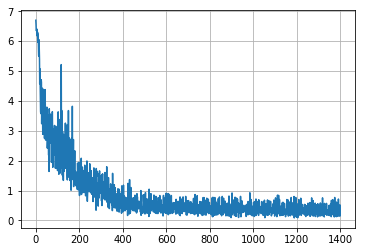

In [28]:
import matplotlib.pyplot as plt

plt.plot(LOSSES)
plt.grid()
plt.show()

## Save model

In [29]:
import datetime
now = datetime.datetime.now().strftime('%Y%m%d_%Hh%M')
now

'20180717_13h39'

In [30]:
torch.save(mynet.state_dict,'./models/'+now+'.pytorch')
#torch.save(mynet,'FishNet_'+now+'.pth')

/anaconda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type FishNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Load model

In [31]:
models_path = glob.glob('./models/*.pytorch')
models_path.sort()
models_path

['./models/20180713_12h50.pytorch',
 './models/20180713_15h24.pytorch',
 './models/20180713_18h53.pytorch',
 './models/20180713_19h33.pytorch',
 './models/20180716_20h21.pytorch',
 './models/20180717_13h39.pytorch']

In [32]:
latest_model = models_path[-1]
mynet.load_state_dict(torch.load(latest_model)())
#mynet.state_dict()
latest_model

'./models/20180717_13h39.pytorch'

## Test step

In [33]:
errors = 0
mynet.eval()

for i, data in enumerate(testset):
    inputs, labels = data
    inputs, labels = Variable(inputs), Variable(labels)
    outputs = mynet(inputs)
    _,y = torch.max(outputs,1)
    errors += (y!=labels).sum().item()
    
accuracy = 1-errors/len(test_ids)  # Previously len(testset which was wrong because it gave the number of batches)
print('{:0.2f}% accuracy on the test set'.format(100*accuracy))

79.31% accuracy on the test set


Other


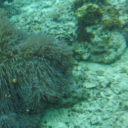

In [34]:
print(RESULT[y[0].item()])
transforms.ToPILImage()(inputs[0].data)

## Logging

In [35]:
with open('log.txt','a') as file:
    file.write('{:0.2f}% accuracy for model {}\n'.format(100*accuracy,now))